In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import naive_bayes
from imblearn import over_sampling
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

### Guassian NB

In [23]:
'''
Create numerical dataset with catagorical label
    - Use discretized citation count as label
    - Drop non-numeric columns
'''

# Load data
data = pd.read_csv('Data/ads_data_clean.csv')
data_GNB = data.copy()

# Create label
citation_count_label = []
for i in range(len(data)):
    row = data.iloc[i]
    label = 'LowCC' if row['citation_count'] <= -0.27 else 'LowMedCC' if  row['citation_count'] <= 0.16 else 'HighMedCC' if row['citation_count'] <= 1.03 else 'HighCC' if row['citation_count'] <= 2.25 else 'VeryHighCC' # label = 'Verylow' if row['citation_count'] < -0.5 else 'Low' if row['citation_count'] < 0 else 'Med' if row['citation_count'] < 1 else 'High' if row['citation_count'] < 2.5 else 'Veryhigh'
    citation_count_label.append(label)
data_GNB['citation_count_label'] = citation_count_label
data_GNB.drop(columns=['citation_count'], inplace=True)

# Drop non-numeric columns
data_GNB.drop(columns=['bibcode', 'doi', 'aff', 'bibstem', 'arxiv_class'], inplace=True)
display(data_GNB)

,author_count,year,read_count,download_count,journal_rank,citation_count_label
0,-0.342659,0.399746,15.781133,0.691080,-0.718169,LowCC
1,0.411490,0.191319,5.439945,4.147883,-0.405034,VeryHighCC
2,-0.342659,1.025027,1.420615,-0.940852,-0.207874,LowCC
3,0.746667,-0.642389,6.174266,3.974185,-0.405034,VeryHighCC
4,-0.334280,-1.267670,3.746686,2.386458,-0.526809,VeryHighCC
...,...,...,...,...,...,...
987,-0.346849,-1.684524,-0.096406,0.183506,-0.613791,LowMedCC
988,-0.149932,-1.892951,0.557356,0.672878,-0.422430,LowMedCC
989,-0.296572,-1.892951,0.151535,0.377487,-0.439827,LowMedCC
990,-0.330090,-1.892951,0.280474,0.536624,3.312001,LowMedCC


In [ ]:
'''
TTS Guassian NB Dataset
  - Same code as in DecTrees - see figure there for oversampling
'''

# Split into X and y and train and test
X = data_GNB.drop(columns=['citation_count_label'])
y = data_GNB['citation_count_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply oversampling to training set
sm = over_sampling.RandomOverSampler(random_state=0)
X_train, y_train = sm.fit_resample(X_train, y_train)

Overall accuracy for Guassian NB: 71.36%


Text(0.5, 1.0, 'Confusion Matrix for DT with Guassian NB')

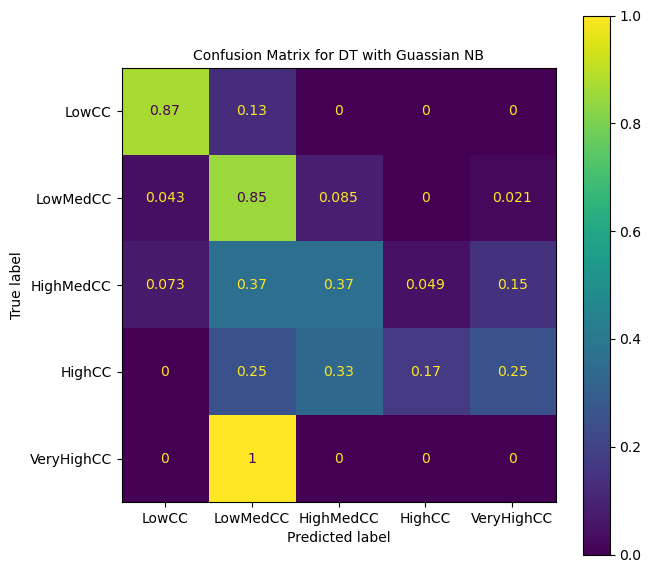

In [ ]:
'''
Fit Guassian NB model and predict
'''
GNB = naive_bayes.GaussianNB()
model = GNB.fit(X_train, y_train)
preds = model.predict(X_test)
print(f'Overall accuracy for Guassian NB: {np.round(metrics.accuracy_score(y_test, preds)*100,2)}%')
cm = metrics.confusion_matrix(y_test, preds, labels=['LowCC', 'LowMedCC', 'HighMedCC', 'HighCC','VeryHighCC'], normalize='true') # print(y_test.value_counts(), print(np.sum(cm, axis=1))) # check that the number of each true label is correct, just for debugging
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['LowCC', 'LowMedCC', 'HighMedCC', 'HighCC', 'VeryHighCC'])
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(ax=ax)
ax.set_title(f'Confusion Matrix for Guassian NB', fontsize=10)

### Categorical and Multinomial NB

In [36]:
'''
Create catagorical dataset
    - Sklearn catagorical NB requires the categorical values to be encoded as integars
    - Turn numeric features into ordinal: Same discretization as for ARM, but use 0, 1, 2, ..., etc instead of strings
    - Turn non-numeric features into nominal: Assign arbitrary integers to each unique value [NOT CURRENTLY DOING THIS, SINCE HARD TO DO WITH LISTS OF VALUES IN AFF AND ARXIV_CLASS]
    - Keep label as categorical strings
'''

# Load data
data = pd.read_csv('Data/ads_data_clean.csv')

# Create catagorical data
data_CNB = pd.DataFrame(columns = ['read_count', 'download_count', 'author_count', 'journal_rank', 'year', 'citation_count_label'])
for i in range(len(data)):
    row = data.iloc[i]
    read_count = 1 if row['read_count'] <= -0.5 else 2 if row['read_count'] <= 0.5 else 3 if row['read_count'] <= 2 else 4 if row['read_count'] <= 4 else 5 # 1900, 6500, 13500, 23000
    download_count = 1 if row['download_count'] <= -0.75 else 2 if row['download_count'] <= 0 else 3 if row['download_count'] <= 1 else 4 if 2 < row['download_count'] <= 3 else 5 # 550, 2000, 4000, 6000, 8000
    author_count = 1 if row['author_count'] <= -0.4 else 2 if row['author_count'] <= -0.3 else 3 if row['author_count'] <= 0.07 else 4 if row['author_count'] <= 3.8 else 5 # 1, 10, 100, 1000
    journal_rank = 1 if row['journal_rank'] <= -0.4 else 2 if row['journal_rank'] <= 0.25 else 3 if  row['journal_rank'] <= 1.5 else 4 if row['journal_rank'] <=  2.5 else 5
    year = 1 if row['year'] <= -1 else 2 if row['year'] <= -0.4 else 3 if row['year'] <= 0.2 else 4 # 2014, 2017, 2020
    citation_count_label = label = 'LowCC' if row['citation_count'] <= -0.27 else 'LowMedCC' if  row['citation_count'] <= 0.16 else 'HighMedCC' if row['citation_count'] <= 1.03 else 'HighCC' if row['citation_count'] <= 2.25 else 'VeryHighCC' #'Verylow' if row['citation_count'] < -0.5 else 'Low' if row['citation_count'] < 0 else 'Med' if row['citation_count'] < 1 else 'High' if row['citation_count'] < 2.5 else 'Veryhigh'
    data_CNB.loc[len(data_CNB)] = {'read_count':read_count, 'download_count':download_count, 'author_count':author_count, 'journal_rank':journal_rank, 'year':year, 'citation_count_label':citation_count_label}
display(data_CNB)

,read_count,download_count,author_count,journal_rank,year,citation_count_label
0,5,3,2,1,4,LowCC
1,5,5,4,1,3,VeryHighCC
2,3,1,2,2,4,LowCC
3,5,5,4,1,2,VeryHighCC
4,4,4,2,1,1,VeryHighCC
...,...,...,...,...,...,...
987,2,3,2,1,1,LowMedCC
988,3,3,3,1,1,LowMedCC
989,2,3,3,1,1,LowMedCC
990,2,3,2,5,1,LowMedCC


In [ ]:
'''
TTS Categorical Dataset
  - Same code as in DecTrees - see figure there for oversampling
'''

# Split into X and y and train and test
X = data_CNB.drop(columns=['citation_count_label'])
y = data_CNB['citation_count_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply oversampling to training set
sm = over_sampling.RandomOverSampler(random_state=0)
X_train, y_train = sm.fit_resample(X_train, y_train)
# display(X_train); display(X_test)

,read_count,download_count,author_count,journal_rank,year
0,2,5,2,1,2
1,2,3,2,3,2
2,2,3,3,1,4
3,1,1,4,2,4
4,2,2,3,1,4
...,...,...,...,...,...
1945,4,4,4,1,1
1946,4,4,4,1,1
1947,3,2,4,1,3
1948,4,4,5,2,2


,read_count,download_count,author_count,journal_rank,year
213,3,3,3,1,1
331,3,5,3,5,1
501,1,1,3,1,4
309,1,2,4,2,4
88,2,2,4,1,2
...,...,...,...,...,...
705,1,1,3,5,4
305,1,2,4,2,4
809,2,2,2,4,1
237,1,2,3,1,4


Overall accuracy for Guassian NB: 69.85%


Text(0.5, 1.0, 'Confusion Matrix for Categorical NB')

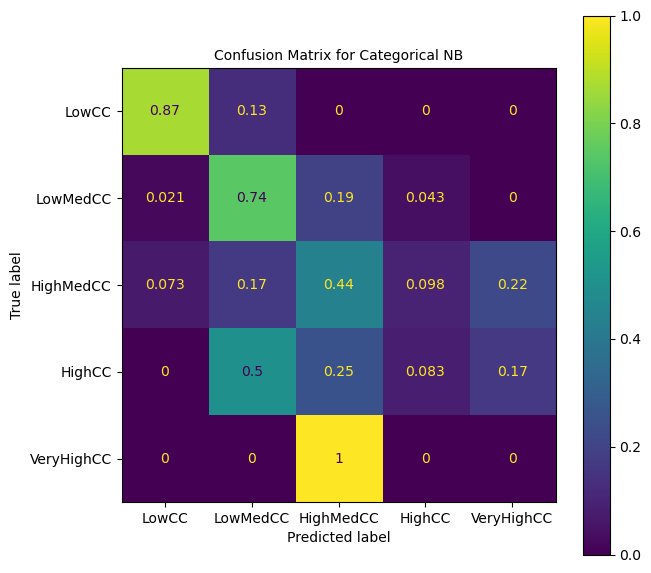

In [41]:
'''
Fit Categorical NB model and predict
'''
CNB = naive_bayes.CategoricalNB()
model = CNB.fit(X_train, y_train)
preds = model.predict(X_test)
print(f'Overall accuracy for Guassian NB: {np.round(metrics.accuracy_score(y_test, preds)*100,2)}%')
cm = metrics.confusion_matrix(y_test, preds, labels=['LowCC', 'LowMedCC', 'HighMedCC', 'HighCC','VeryHighCC'], normalize='true') # print(y_test.value_counts(), print(np.sum(cm, axis=1))) # check that the number of each true label is correct, just for debugging
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['LowCC', 'LowMedCC', 'HighMedCC', 'HighCC', 'VeryHighCC'])
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(ax=ax)
ax.set_title(f'Confusion Matrix for Categorical NB', fontsize=10)

Overall accuracy for Guassian NB: 55.78%


Text(0.5, 1.0, 'Confusion Matrix for Multinomial NB')

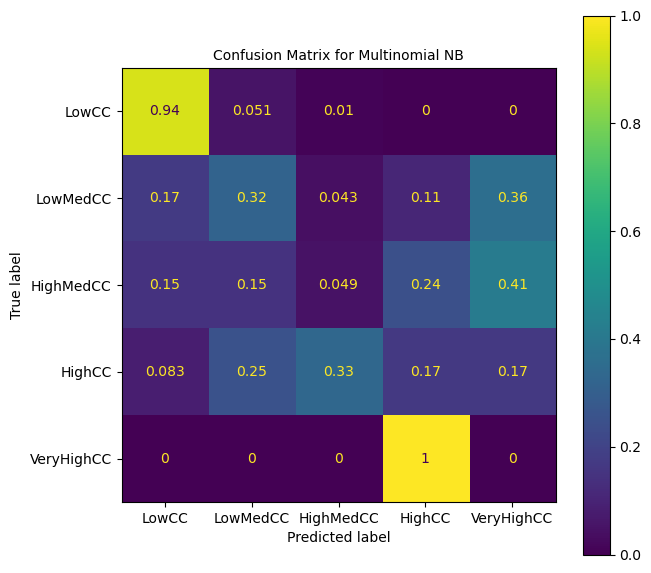

In [42]:
'''
Fit Multinomial NB model and predict
'''
MNB = naive_bayes.MultinomialNB()
model = MNB.fit(X_train, y_train)
preds = model.predict(X_test)
print(f'Overall accuracy for Guassian NB: {np.round(metrics.accuracy_score(y_test, preds)*100,2)}%')
cm = metrics.confusion_matrix(y_test, preds, labels=['LowCC', 'LowMedCC', 'HighMedCC', 'HighCC','VeryHighCC'], normalize='true') # print(y_test.value_counts(), print(np.sum(cm, axis=1))) # check that the number of each true label is correct, just for debugging
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['LowCC', 'LowMedCC', 'HighMedCC', 'HighCC', 'VeryHighCC'])
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(ax=ax)
ax.set_title(f'Confusion Matrix for Multinomial NB', fontsize=10)